# Example of creating a synthetic dust polarization map

In [1]:
import sys
sys.path.append("../module/") #add path for import
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import tigress_read #scripts for reading data
import yt #https://yt-project.org/

/Users/ckim/miniconda3/envs/packaging/lib/python3.8/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /Users/ckim/.config/yt/ytrc is deprecated in favor of /Users/ckim/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg


## Reading data (assuming that you've already downloaded the relevant data)

if not, run this
```
model.download(300,dataset="history")
model.download(300,dataset="input")
model.download(300,dataset="MHD")
```

In [2]:
#master directory of where the data is stored
dir_master = "../data/" #this is default
model_id = "R8_4pc" #name of the simulation model
model = tigress_read.Model(model_id, dir_master=dir_master) #reading the model information

In [3]:
#load the MHD data set for the snapshot ivtk=300
model.load(300, dataset="MHD")

Because we use the python package [YT](https://yt-project.org/) to read the outputs from the MHD simulation, the data stored in the YT format. This means that all fields (such as density, velocity, H2 and CO abundances) in the data has *units* atached. 

Let's convert the YT covering grid into numpy arrray with appropriate units. Magnetic fields are in the code units so that `Pmag = B^2/2`. In the dust polarization map constructino, only the ratio of different B components matters so that the units are not important for now. Also, I take transpose so that the array is in the original C-like ordering `(z,y,x)`

In [4]:
Temp = model.MHD.grid['temperature_init'].in_units("K").value.T
nH = model.MHD.grid['nH'].in_units("cm**-3").value.T
Bx = model.MHD.grid['cell_centered_B_x'].value.T
By = model.MHD.grid['cell_centered_B_y'].value.T
Bz = model.MHD.grid['cell_centered_B_z'].value.T

Retrieve cell-centered coordinates for later uses.

In [5]:
xcc, ycc, zcc = model.MHD.grid["x"][:,0,0].to('pc').value, model.MHD.grid["y"][0,:,0].to('pc').value, model.MHD.grid["z"][0,0,:].to('pc').value

/Users/ckim/miniconda3/envs/packaging/lib/python3.8/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'athena', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("athena", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/ckim/miniconda3/envs/packaging/lib/python3.8/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'athena', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "y")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/ckim/miniconda3/envs/packaging/lib/python3.8/site-packages/yt/data_objec

Get cell size in pc and cm for convenience (note that the cell is cubic)

In [6]:
dx_pc = model.MHD.grid['dx'][0,0,0].to('pc').value
dx_cm = model.MHD.grid['dx'][0,0,0].to('cm').value

/Users/ckim/miniconda3/envs/packaging/lib/python3.8/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'dx' is ambiguous and corresponds to any one of the following field types:
 {'athena', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "dx")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)


In [7]:
from synthetic_dustpol import calc_IQU

In [8]:
I,Q,U = calc_IQU(nH,Bx,By,Bz,dx_pc,los='y')

## Projected column density and I

In [9]:
plt.rcParams['figure.dpi']=200

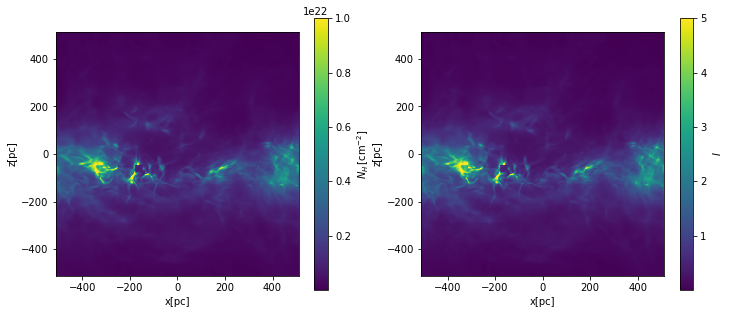

In [10]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
# integration along the y-axis (edge on view)
plt.sca(axes[0])
NH = nH.sum(axis=1)*dx_cm

plt.pcolormesh(xcc,zcc,NH,vmax=1.e22,shading='nearest')
plt.gca().set_aspect('equal')
plt.xlabel('x[pc]')
plt.ylabel('z[pc]')
cbar = plt.colorbar(label=r'$N_H\,[{\rm cm^{-2}}]$')

plt.sca(axes[1])

plt.pcolormesh(xcc,zcc,I,vmax=5,shading='nearest')
plt.gca().set_aspect('equal')
plt.xlabel('x[pc]')
plt.ylabel('z[pc]')
cbar = plt.colorbar(label=r'$I$')

## Polarization fraction, Q, and U maps

In [11]:
P = np.sqrt(Q**2+U**2)

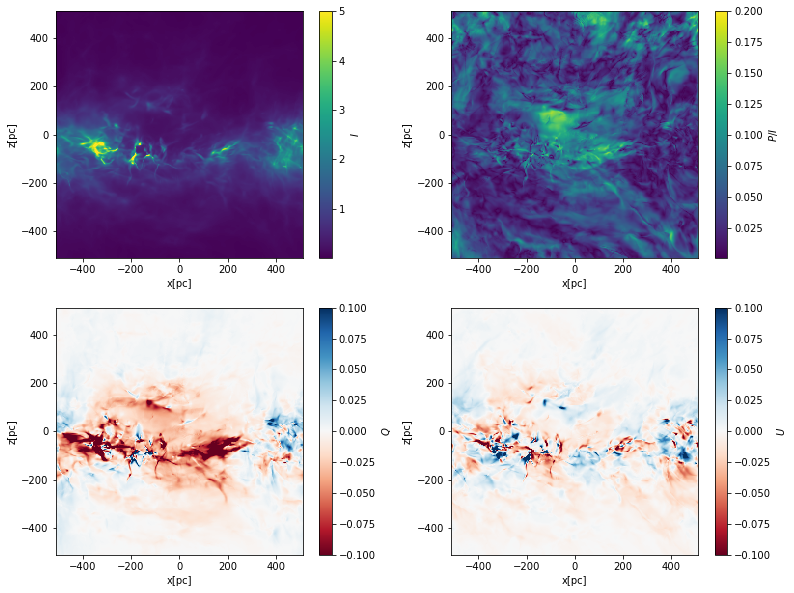

In [12]:
fig, axes = plt.subplots(2,2, figsize=(13,10))
axes = axes.flatten()
# integration along the y-axis (edge on view)
plt.sca(axes[0])
plt.pcolormesh(xcc,zcc,I,vmax=5,shading='nearest')
plt.gca().set_aspect('equal')
plt.xlabel('x[pc]')
plt.ylabel('z[pc]')
cbar = plt.colorbar(label=r'$I$')
plt.sca(axes[1])
plt.pcolormesh(xcc,zcc,P/I,vmax=0.2,shading='nearest')
plt.gca().set_aspect('equal')
plt.xlabel('x[pc]')
plt.ylabel('z[pc]')
cbar = plt.colorbar(label=r'$P/I$')

plt.sca(axes[2])
plt.pcolormesh(xcc,zcc,Q,vmin=-0.1,vmax=0.1,shading='nearest',cmap=plt.cm.RdBu)
plt.gca().set_aspect('equal')
plt.xlabel('x[pc]')
plt.ylabel('z[pc]')
cbar = plt.colorbar(label=r'$Q$')
plt.sca(axes[3])
plt.pcolormesh(xcc,zcc,U,vmin=-0.1,vmax=0.1,shading='nearest',cmap=plt.cm.RdBu)
plt.gca().set_aspect('equal')
plt.xlabel('x[pc]')
plt.ylabel('z[pc]')
cbar = plt.colorbar(label=r'$U$')